# Projekat 1 - 40 bodova

U VCF fajlu su dati rezultati studije u kojoj su prikupljani podaci o mutacijama u određenoj populaciji (tabela sa imenom eksperimenta koji je dodeljen svakom studentu je data u fajlu Lista zadataka 2020). Osobe zahvaćene nekom bolešću su označene kao *case_x*, a zdrave osobe sa *control_x*.

Kao rezultat projekta se potrebno je predati:  
1. Kod kojim su generisani rezultati (ipynb ili python skripta)
2. Kraći izveštaj sa tekstualnim odgovorima na pitanja i grafikonima

Projekat je moguće raditi pojedinačno ili u paru. **Ukoliko se projekat radi u paru, svaki student predaje i brani projekat posebno, uz napomenu da je projekat urađen u paru; pri tome svaki student treba da obradi podatke iz eksperimenta koji mu dodeljen, a rad u paru se odnosi na programski kod i šablon za tekstualni izveštaj.**

Pitanja:

1. [3 boda] Koliko je subjekata ukupno učestvovalo u studiji? Koliko njih su oboleli, a koliko zdravi?
 
2. [5 bodova] Koliko je ukupno mutacija posmatrano u populaciji. Dati tabelu sa brojem mutacija po hromozomu.
   
3. [8 bodova] Nacrtati histograme:  
  3a. [2 boda] Frekvencije ređih alela (minor allele frequency, MAF) za svaku mutaciju u studiji  
  3b. [2 boda] Procenat homozigotnih referentnih uzoraka za svaku mutacija u studiji  
  3c. [2 boda] Procenat homozigotnih alternativnih uzoraka za svaku mutacija u studiji  
  3d. [2 boda] Procenat heterozigotnih uzoraka za svaku mutacija u studiji     
      
4. [17 bodova] Identifikovati mutacije koje su statistički značajno asocirane sa datom bolešću (p manje od 0.05, upotrebom hi kvadrat testa).  
  4a. [5 bodova] Primeniti hi kvadrat test na sve mutacije u studiji
  4b. [3 bodova] Da li je potrebno izvršiti korekciju za višestruko testiranje? Ukoliko jeste, objasniti kako, i primeniti je.  
  4c. [4 bodova] Nacrtati Menhetn grafikon. Voditi računa da dužina duž X ose alocirana svakom hromozomu bude proporcionalna dužini hromozoma.  
  4d. [5 bodova] Za svaku mutaciju koja je statistički značajno asocirana sa datom bolešću odrediti da li odstupa od Hardi-Vajnberg ekvilibrijuma (upotrebom hi kvadrat testa).

5. [7 bodova] Na osnovu mutacije koja pokazuje najjaču asocijaciju sa bolešću odrediti region na referentnom genomu gde se verovatno nalazi gen koji uzrokuje bolest.
  5a. [4 boda] Identifikovati jedan ili više mogućih gena upotrebom [UCSC Genome browsera](https://genome.ucsc.edu/cgi-bin/hgGateway?redirect=manual&source=genome.ucsc.edu). Studija je rađena prema GRCH37 referentnom genomu.
  5b. [3 boda] Izvući podatke o bolestima vezanim za identifikovane gene sa [OMIM sajta](https://omim.org) (nije potrebno prevoditi na srpski jezik).

Mount Google Drive to access VCF



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Unzip VCF archive if needed

In [0]:
!gunzip /content/drive/My\ Drive/Colab\ Notebooks/experiment_11.vcf.gz

Install Pysam library to parse VCF

In [0]:
!pip install pysam

Import required libraries

In [0]:
import math
import pysam
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from itertools import groupby
from collections import Counter

Open VCF

In [0]:
vcf = pysam.VariantFile('/content/drive/My Drive/Colab Notebooks/experiment_11.vcf')

Count samples

In [0]:
cases = {sample for sample in vcf.header.samples if sample.startswith('case')}
controls = {sample for sample in vcf.header.samples if sample.startswith('control')}

In [0]:
print('Total: {}, Case: {}, Control: {}'.format(len(cases) + len(controls), len(cases), len(controls)))

Total: 200, Case: 100, Control: 100


Fetch all mutations

In [0]:
variants = list(vcf.fetch())

Count mutations

In [0]:
def get_muts_per_chrom():
    muts_per_chrom = {}

    for variant in variants:
        if variant.chrom in muts_per_chrom:
            muts_per_chrom[variant.chrom] += 1
        else:
            muts_per_chrom[variant.chrom] = 1

    return muts_per_chrom

Show mutations per chromosome table

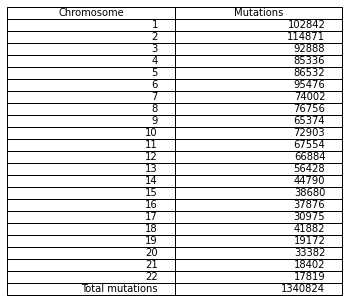

In [0]:
mpc = get_muts_per_chrom()
freq_data = [[k, v] for k, v in mpc.items()]

muts_total = sum(mpc.values())
freq_data.append(['Total mutations', muts_total])

freq_table = plt.table(cellText=freq_data, colLabels=['Chromosome', 'Mutations'], loc='center')

plt.axis('off')
plt.show()

Extract Minor Allele Frequency (MFA) and sampled genotypes per mutation

In [0]:
def gts_per_mut(variant):
    samples_total = len(variant.samples)

    ref_sum = 0
    alt_sum = 0
    het_sum = 0

    for sample in variant.samples:
        data = variant.samples[sample]
        gt = sum(data['GT'])

        if gt == 0:
            ref_sum += 1
        elif gt == 2:
            alt_sum += 1
        else:
            het_sum += 1

    maf_pct = (2 * min(ref_sum, alt_sum) + het_sum) / (2 * samples_total)
    ref_pct = ref_sum / samples_total
    alt_pct = alt_sum / samples_total
    het_pct = het_sum / samples_total

    return maf_pct, ref_pct, alt_pct, het_pct

Group mutations by genotype

In [0]:
def get_gts():
    maf_list = []
    ref_list = []
    alt_list = []
    het_list = []

    for variant in variants:
        maf, ref, alt, het = gts_per_mut(variant)

        maf_list.append(maf)
        ref_list.append(ref)
        alt_list.append(alt)
        het_list.append(het)

    return maf_list, ref_list, alt_list, het_list

In [0]:
%%time
maf, ref, alt, het = get_gts()

CPU times: user 4min 41s, sys: 237 ms, total: 4min 41s
Wall time: 4min 41s


Show histograms

In [0]:
def show_hist(data, label, index_max, index_curr):
    plt.subplot(1, index_max, index_curr)
    plt.hist(data, bins=25, label=label)
    plt.legend()

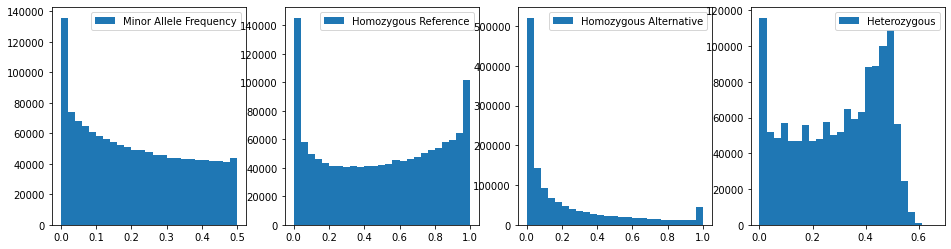

In [0]:
plt.figure(figsize=(16, 4))

show_hist(maf, 'Minor Allele Frequency', 4, 1)
show_hist(ref, 'Homozygous Reference', 4, 2)
show_hist(alt, 'Homozygous Alternative', 4, 3)
show_hist(het, 'Heterozygous', 4, 4)

Run Chi-Square test for each mutation

In [0]:
def run_chi2(variant):
    case_refs = sum(1 for sample in cases for gt in variant.samples[sample]['GT'] if gt == 0)
    case_alts = sum(1 for sample in cases for gt in variant.samples[sample]['GT'] if gt == 1)
    control_refs = sum(1 for sample in controls for gt in variant.samples[sample]['GT'] if gt == 0)
    control_alts = sum(1 for sample in controls for gt in variant.samples[sample]['GT'] if gt == 1)

    if (case_refs + case_alts == 0
        or control_refs + control_alts == 0
        or case_refs + control_refs == 0
        or case_alts + control_alts == 0):
        return None

    total = case_refs + case_alts + control_refs + control_alts

    observed = [case_refs, case_alts, control_refs, control_alts]
    expected = [(case_refs + case_alts) * (case_refs + control_refs) / total,
                (case_refs + case_alts) * (case_alts + control_alts) / total,
                (control_refs + control_alts) * (case_refs + control_refs) / total,
                (control_refs + control_alts) * (case_alts + control_alts) / total]

    return chisquare(observed, expected, ddof=2).pvalue

In [0]:
%%time
chi2_raw = [(variant.chrom, variant.pos, run_chi2(variant)) for variant in variants]
chi2 = [x for x in chi2_raw if x[2] is not None]
results = {k: list(v) for k, v in groupby(chi2, key=lambda x: x[0])}

CPU times: user 10min 55s, sys: 1.26 s, total: 10min 57s
Wall time: 10min 57s


Calculate chromosome lengths

In [0]:
def chrom_lengths():
    lengths = []

    chrom_groups = groupby(variants, key=lambda v: v.chrom)

    for _, group in chrom_groups:
        lengths.append(max([v.pos for v in group]))

    return lengths

Show Manhattan plot

In [0]:
def show_manhattan(bonferroni = False):
    lengths = chrom_lengths()
    widths = [math.ceil(100 * x / sum(lengths)) for x in lengths]

    plt.figure(figsize=(16, 4))

    sep = 0.01

    if bonferroni:
        sep /= muts_total

    for i, chrom in enumerate(results):
        pos = [x[1] for x in results[chrom]]
        p = [-np.log10(x[2]) for x in results[chrom]]

        plt.subplot2grid((1, sum(widths)), (0, sum(widths[:i])), colspan=widths[i])
        plt.scatter(pos, p)
        plt.ylim(0, 13)
        plt.axhline(-np.log10(sep), c='r')

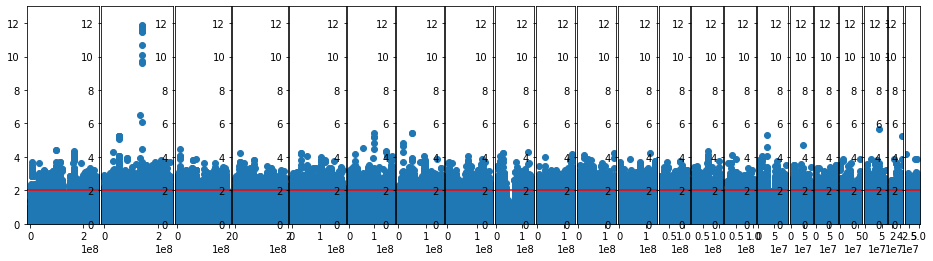

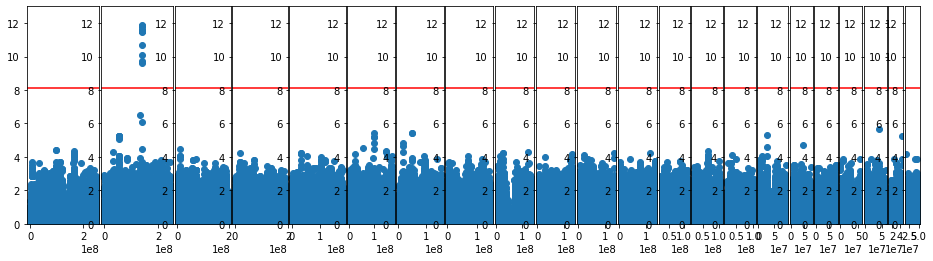

In [0]:
show_manhattan()
show_manhattan(True)

Extract regions with most significant mutations

In [0]:
def get_regions():
    regions = []
    
    for i, chrom in enumerate(results):
        pos = [x[1] for x in results[chrom]]
        p = [-np.log10(x[2]) for x in results[chrom]]

        upper = [x for x in p if x > -math.log10(0.01 / muts_total)]

        pos_min = float('inf')
        pos_max = float('-inf')
    
        for j, x in enumerate(p):
            if x in upper:
                pos_min = min(pos_min, pos[j])
                pos_max = max(pos_max, pos[j])

        if pos_min != float('inf') and pos_max != float('-inf'):
            regions.append({'chrom' : i + 1, 'start' : pos_min, 'end' : pos_max})

    return regions

Check if mutation is inside region

In [0]:
def isinside(mut, region):
    return int(mut.chrom) == region['chrom'] and mut.pos >= region['start'] and mut.pos <= region['end']

In [0]:
variants_ext = [v for r in get_regions() for v in variants if isinside(v, r)]

Check Hardy-Weinberg equilibrium for each significant mutation

In [0]:
def check_hwe(variant):
    counts = Counter([sum(sample['GT']) for sample in variant.samples.values() if None not in sample['GT']])
    total = sum(counts.values())
    
    p = (2 * counts[0] + counts[1]) / (2 * total)
    q = (2 * counts[2] + counts[1]) / (2 * total)
    
    if p == 0 or q == 0:
        return None

    observed = [counts[0], counts[1], counts[2]]
    expected = [p * p * total, 2 * p * q * total, q * q * total]

    return chisquare(observed, expected, ddof=1).pvalue

In [0]:
%%time
hwe_raw = [check_hwe(v) for v in variants_ext]
hwe = [x > 1e-6 for x in hwe_raw if x is not None]

CPU times: user 14.4 ms, sys: 1.05 ms, total: 15.5 ms
Wall time: 13.3 ms


Show HWE results for each significant mutation

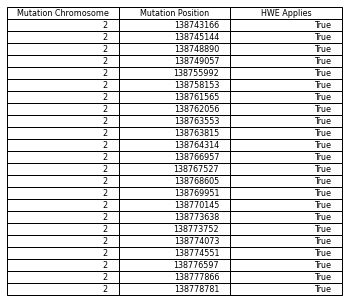

In [0]:
hwe_data = [[v.chrom, v.pos, h] for (v, h) in zip(variants_ext, hwe)]

hwe_table = plt.table(cellText=hwe_data, colLabels=['Mutation Chromosome', 'Mutation Position', 'HWE Applies'], loc='center')

plt.axis('off')
plt.show()

Show all significant regions

Extract relevant genes in this regions using [UCSC Genome browser](https://genome.ucsc.edu/cgi-bin/hgGateway?redirect=manual&source=genome.ucsc.edu)

In [0]:
for region in get_regions():
    print('chr{}:{}-{}'.format(region['chrom'], region['start'], region['end']))

chr2:138743166-138778828
